# Credential Access - DCSync

#### Author: Rifqi Ardia Ramadhan

DCSync is a credential dumping method by impersonating a Domain Controller (DC) that requested the credential hashes to another DC. This method is popular due to the lack of necessity to drop malicious code or log in the machine, making it hard to detect. It has some limitations, but it's still a powerful tool nonetheless.

How it works, more or less, I'm simplifying the steps to make it understandable to people:

0. Directory Replication Service Remote Protocol (MS-DRSR) is a legit AD service that cannot be disabled.
1. Against a domain account with domain replication privileges to "ask" for hashes. This domain account is MS-DRSR.
2. A compromised accound with enough permissions will target a domain, for example a KRBTGT domain.
3. Attacker, using a tool, pretends to be a domain controller will then ask for hashes to another domain controllers without executing any code on the target using MS-DRSR protocol via `DsGetNCChanges`. This protocol is useful for detection later.
4. Earlier (than NTLM) password hashes may also be returned.


## Use Case
### Objective
Identify if there is any non-DC host that is using DRSUAPI protocol to request abnormal request. DRSUAPI is an MS-DRSR protocol. More information about DRSUAPI is on References section. This use case specifically try to detect from network traffic.

### Log Requirements
RPC traffic

### Characteristics
| No | Characteristic | Note | Why|
|----|----------------|------|---|
|  1 | DRSUAPI RPC request for `DsGetNCChanges`\*| | `DsGetNCChanges` is a function to get object updates from the requested server.|
|2   | Check the source host of the step 1. If the host is not on Domain Controller list, then a DCSync attack may be occurred.|||
| 3 | Event ID 4662 on Windows Security Auditing occurred and has property field of `{1131f6ad-9c07-11d1-f79f-00c04fc2dcd2}`which is the control access rights GUID for replicating directory changes.\*\*|Non-network|This characteristic is outside of this Network section of Threat Hunting, but it'll be useful, I promise.|

\*: DCSync is quite hard to actually look into due to the vagueness of the object replicated on `DsGetNCChanges`. More investment in packet analysis might help to determine the occurrence.

\*\*: Active Directory event logs only reveal which objects were replicated when diagnostic logging is enabled. Diagnostic logging can have performance impact and is not likely suitable for long-term production use.

### References
https://attack.mitre.org/techniques/T1003/006/

https://www.qomplx.com/kerberos_dcsync_attacks_explained

https://attack.stealthbits.com/privilege-escalation-using-mimikatz-dcsync

https://wiki.samba.org/index.php/DRSUAPI

https://adsecurity.org/?p=1729

### Sample
Dataset acquired from [Pcaps](https://github.com/elcabezzonn/Pcaps) by elcabezzonn.

Useful Wireshark filter:

```drsuapi.opnum == 3```

`opnum 3` means that the request is `DsGetNCChanges`.

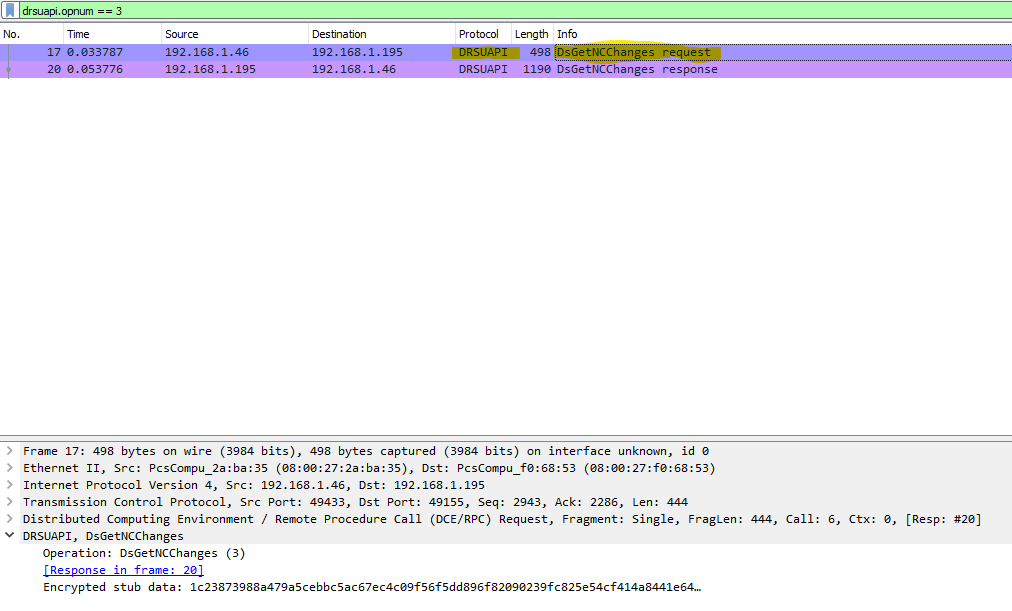

You can see it's a bit tricky to determine the object with Wireshark because it's encrypted by default on RPC protocol.